# Initialization

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import time

# Data preprocessing (only need to be run once on the whole dataset)
# DON'T RUN IF YOU HAVE THE DATASETS ALREADY

This part is my codes to process the dataset as we discussed with TA.

The processed datasets are in the shared folder so you don't need to run this part again. It's time & GPU consuming.
- train_images.npz
- val_images.npz
- test_images.npz
- train_labels.csv
- val_labels.csv
- test_labels.csv

Final size of training set is 29883, validation is 6403, testing is 6407.

In [ ]:
data = np.load('drive/MyDrive/CSE547/project/data.npz')

In [ ]:
#  List all arrays in the .npz file
print(len(data.files))

78560


In [ ]:
print(f"arr_2: {data['arr_2']}")

arr_2: [28 25 19 ...  0  0  0]


In [ ]:
meta_data = pd.read_csv('drive/MyDrive/CSE547/project/data.csv', sep='\t')

In [ ]:
meta_data

,case,StudyDescription,SeriesDescription,pixel_array,class
0,1,Intraop,2D_AX_T2_BLADE,[8 5 8 ... 0 0 0],Astrocytoma
1,1,Intraop,2D_AX_T2_BLADE,[13 12 13 ... 0 1 0],Astrocytoma
2,1,Intraop,2D_AX_T2_BLADE,[28 25 19 ... 0 0 0],Astrocytoma
3,1,Intraop,2D_AX_T2_BLADE,[ 9 23 27 ... 0 0 0],Astrocytoma
4,1,Intraop,2D_AX_T2_BLADE,[22 13 7 ... 0 1 0],Astrocytoma
...,...,...,...,...,...
78555,114,Preop,3D_AX_T1_postcontrast,[ 3 6 10 ... 4 6 8],Glioblastoma
78556,114,Preop,3D_AX_T1_postcontrast,[10 10 10 ... 9 6 4],Glioblastoma
78557,114,Preop,3D_AX_T1_postcontrast,[ 3 4 5 ... 11 9 7],Glioblastoma
78558,114,Preop,3D_AX_T1_postcontrast,[10 12 15 ... 5 5 5],Glioblastoma


In [ ]:
meta_data['class'].value_counts()

class
Astrocytoma               23362
Glioblastoma              21956
Oligodendroglioma         16894
abnormality               11585
DENT                       1187
Glioneuronal                785
Glioma                      781
Ependymomas                 779
Papillary Glioneuronal      757
Atypical meningioma         474
Name: count, dtype: int64

In [ ]:
# Step 1: Count the occurrences of each class
class_counts = meta_data['class'].value_counts()

# Step 2: Identify classes with counts >= 10,000
sufficient_class_counts = class_counts[class_counts >= 10000].index

# Step 3: Filter the DataFrame to keep only rows with sufficient class counts
filtered_meta_data = meta_data[meta_data['class'].isin(sufficient_class_counts)]

In [ ]:
filtered_meta_data['class'].value_counts()

class
Astrocytoma          23362
Glioblastoma         21956
Oligodendroglioma    16894
abnormality          11585
Name: count, dtype: int64

In [ ]:
filtered_meta_data['case'].value_counts()

case
69     1275
24     1041
81     1040
110    1025
88     1025
       ... 
34      476
84      466
99      442
113     421
108     399
Name: count, Length: 107, dtype: int64

In [ ]:
# Down sampling
num_samples_per_case = 399

grouped = filtered_meta_data.groupby('case')

# Apply random sampling to each group
sampled_groups = grouped.apply(lambda x: x.sample(n=num_samples_per_case, random_state=0) if len(x) > num_samples_per_case else x)

# Remove the extra index level introduced by groupby apply
sampled_groups.index = sampled_groups.index.droplevel(0)

In [ ]:
sampled_groups

,case,StudyDescription,SeriesDescription,pixel_array,class
540,1,Preop,3D_AX_T1_postcontrast,[16 12 9 ... 19 15 9],Astrocytoma
467,1,Preop,3D_AX_T1_postcontrast,[11 11 9 ... 9 8 8],Astrocytoma
355,1,Preop,3D_SAG_T2_SPACE,[1 1 1 ... 5 3 2],Astrocytoma
172,1,Intraop,3D_AX_T1_precontrast,[29 31 34 ... 0 0 0],Astrocytoma
637,1,Preop,2D_COR_T2_BLADE,[ 6 5 5 ... 5 3 10],Astrocytoma
...,...,...,...,...,...
77662,114,Intraop,2D_AX_T2_BLADE,[22 24 22 ... 42 34 26],Glioblastoma
77892,114,Intraop,3D_SAG_T2_FLAIR,[ 6 6 6 ... 118 100 79],Glioblastoma
78083,114,Preop,2D_AX_T2_BLADE,[0 1 0 ... 0 0 0],Glioblastoma
77653,114,Intraop,2D_AX_T2_BLADE,[44 36 39 ... 24 15 20],Glioblastoma


In [ ]:
from sklearn.model_selection import train_test_split

grouped = sampled_groups.groupby('class')

def split_group(group):
    train, temp = train_test_split(group, test_size=0.3, random_state=0)
    val, test = train_test_split(temp, test_size=0.5, random_state=0)
    return train, val, test

train_list = []
val_list = []
test_list = []

for name, group in grouped:
    train, val, test = split_group(group)
    train_list.append(train)
    val_list.append(val)
    test_list.append(test)

train_data = pd.concat(train_list)
val_data = pd.concat(val_list)
test_data = pd.concat(test_list)

# Print the shapes of the resulting sets to verify
print(f"Training set shape: {train_data.shape}")
print(f"Validation set shape: {val_data.shape}")
print(f"Testing set shape: {test_data.shape}")


Training set shape: (29883, 5)
Validation set shape: (6403, 5)
Testing set shape: (6407, 5)


In [ ]:
train_data.head(10)

,case,StudyDescription,SeriesDescription,pixel_array,class
5780,9,Intraop,3D_SAG_T2_FLAIR,[ 2 3 4 ... 27 26 26],Astrocytoma
41892,62,Intraop,3D_AX_T1_postcontrast,[0 0 0 ... 0 0 0],Astrocytoma
50748,74,Intraop,3D_AX_T1_precontrast,[5 6 7 ... 8 7 7],Astrocytoma
66607,97,Preop,3D_AX_T1_postcontrast,[ 0 0 0 ... 10 8 7],Astrocytoma
33034,48,Preop,3D_AX_T1_postcontrast,[0 0 0 ... 0 0 0],Astrocytoma
28172,41,Intraop,3D_SAG_T2_FLAIR,[ 3 3 4 ... 26 24 20],Astrocytoma
28065,41,Preop,2D_COR_T2_BLADE,[ 5 8 11 ... 9 9 13],Astrocytoma
39774,59,Preop,3D_AX_T1_postcontrast,[0 0 0 ... 7 7 7],Astrocytoma
40653,60,Preop,2D_AX_T2,[9 9 7 ... 4 5 5],Astrocytoma
73513,108,Intraop,2D_AX_T2_BLADE,[0 4 7 ... 4 4 3],Astrocytoma


In [ ]:
# Load the .npz file
image_data = np.load('drive/MyDrive/CSE547/project/data.npz')

# Function to retrieve images by indices
def get_images_by_indices(indices, image_data):
    images = []
    for index in indices:
        key = f'arr_{index}'
        if key in image_data:
            images.append(image_data[key])
    return np.array(images)

# Assuming 'train_data', 'val_data', and 'test_data' are your DataFrames with the original indices
train_indices = train_data.index
val_indices = val_data.index
test_indices = test_data.index

# Retrieve images for each set
train_images = get_images_by_indices(train_indices, image_data)
val_images = get_images_by_indices(val_indices, image_data)
test_images = get_images_by_indices(test_indices, image_data)

In [ ]:
# # Save the images into new .npz files to session memory
# np.savez('train_images.npz', *train_images)
# np.savez('val_images.npz', *val_images)
# np.savez('test_images.npz', *test_images)

In [ ]:
# Save the images into new .npz files
np.savez('drive/MyDrive/CSE547/project/train_images.npz', *train_images)
np.savez('drive/MyDrive/CSE547/project/val_images.npz', *val_images)
np.savez('drive/MyDrive/CSE547/project/test_images.npz', *test_images)

In [ ]:
# Select the 'class' and 'case' columns
train_labels = train_data[['class', 'case']]
val_labels = val_data[['class', 'case']]
test_labels = test_data[['class', 'case']]

In [ ]:
# # Save the labels into CSV files with the index to session memory
# train_labels.to_csv('train_labels.csv', index=True)
# val_labels.to_csv('val_labels.csv', index=True)
# test_labels.to_csv('test_labels.csv', index=True)

In [ ]:
# Save the labels into CSV files to my drive folder
train_labels.to_csv('drive/MyDrive/CSE547/project/train_labels.csv', index=True)
val_labels.to_csv('drive/MyDrive/CSE547/project/val_labels.csv', index=True)
test_labels.to_csv('drive/MyDrive/CSE547/project/test_labels.csv', index=True)

# Training Process

## Image data loading

In [ ]:
train_images = np.load('drive/MyDrive/CSE547/project/train_images.npz')
val_images = np.load('drive/MyDrive/CSE547/project/val_images.npz')
test_images = np.load('drive/MyDrive/CSE547/project/test_images.npz')

In [ ]:
len(train_images.files)

29883

In [ ]:
# If you want to convert all arrays to a list of NumPy arrays
train_images = [train_images[key] for key in train_images.files]
train_images = np.array(train_images)

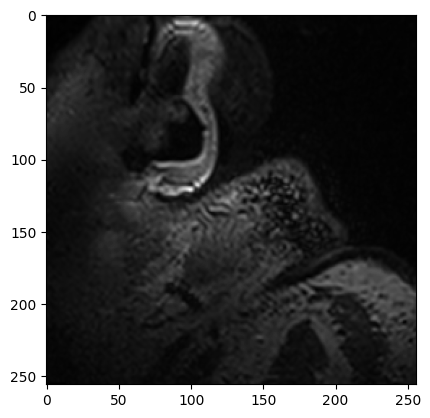

In [ ]:
# sample_normalized = pd.read_csv('drive/MyDrive/CSE547/project/data.npz', header=None)

plt.imshow(train_images[0].reshape((256,256)), cmap='gray')
plt.show()

In [ ]:
train_images.shape

(29883, 65536)

In [ ]:
train_images=train_images.reshape(29883,256,256)

In [ ]:
val_images = [val_images[key] for key in val_images.files]
val_images = np.array(val_images)
val_images=val_images.reshape(6403,256,256)

In [ ]:
test_images = [test_images[key] for key in test_images.files]
test_images = np.array(test_images)
test_images=test_images.reshape(6407,256,256)

In [ ]:
train_labels = pd.read_csv('drive/MyDrive/CSE547/project/train_labels.csv')
val_labels = pd.read_csv('drive/MyDrive/CSE547/project/val_labels.csv')
test_labels = pd.read_csv('drive/MyDrive/CSE547/project/test_labels.csv')

In [ ]:
train_labels

,Unnamed: 0,class,case
0,5780,Astrocytoma,9
1,41892,Astrocytoma,62
2,50748,Astrocytoma,74
3,66607,Astrocytoma,97
4,33034,Astrocytoma,48
...,...,...,...
29878,49517,abnormality,72
29879,28827,abnormality,42
29880,21035,abnormality,30
29881,24907,abnormality,36


In [ ]:
train_labels['class'].value_counts()

class
Astrocytoma          9216
Glioblastoma         8658
Oligodendroglioma    6703
abnormality          5306
Name: count, dtype: int64

In [ ]:
import tensorflow as tf
from keras.applications.densenet import DenseNet121,preprocess_input

model = DenseNet121(include_top=False,
                    weights='imagenet',
                    input_tensor=None,
                    pooling=None)

# model.summary()

In [ ]:
import keras
from keras.models import Model
from keras.layers import Flatten,Dense, GlobalAveragePooling2D
inputs = keras.Input(shape=(224,224,3))
x = GlobalAveragePooling2D()(model.output)
#x=Flatten()(x)
outputs = Dense(4, activation='softmax')(x)

new_model = Model(inputs=model.input, outputs=outputs)
for layer in new_model.layers[:-10]:
    layer.trainable = False
# new_model.summary()

In [ ]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
classes=train_labels['class']
label_encoder = LabelEncoder()
integer_labels = label_encoder.fit_transform(classes)
train_labels= to_categorical(integer_labels)

classes=val_labels['class']
label_encoder = LabelEncoder()
integer_labels = label_encoder.fit_transform(classes)
val_labels= to_categorical(integer_labels)

classes=test_labels['class']
label_encoder = LabelEncoder()
integer_labels = label_encoder.fit_transform(classes)
test_labels= to_categorical(integer_labels)

In [ ]:
train_images=np.stack((train_images,) * 3, axis=-1)
val_images=np.stack((val_images,) * 3, axis=-1)
test_images=np.stack((test_images,) * 3, axis=-1)

In [ ]:
train_images = preprocess_input(train_images)
val_images= preprocess_input(val_images)
test_images=preprocess_input(test_images)

In [ ]:
print(train_labels.shape)
print(val_labels.shape)
print(test_labels.shape)
print(train_images.shape)
print(val_images.shape)
print(test_images.shape)

(29883, 4)
(6403, 4)
(6407, 4)
(29883, 256, 256, 3)
(6403, 256, 256, 3)
(6407, 256, 256, 3)


## Model training

In [ ]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint("drive/MyDrive/CSE547/project/model_checkpoint.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [ ]:
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

learning_rate = 0.0001
optimizer = Adam(learning_rate=learning_rate)

# Define the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

In [ ]:
new_model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

start_time = time.time()
history=new_model.fit(train_images, train_labels, epochs=30, batch_size=32, validation_data=(val_images, val_labels), callbacks=[reduce_lr, checkpoint])
end_time = time.time()

print("Training Time:", end_time - start_time)

Epoch 1/30
934/934 [==============================] - ETA: 0s - loss: 1.3345 - accuracy: 0.3648
Epoch 1: val_accuracy improved from -inf to 0.42308, saving model to drive/MyDrive/CSE547/project/model_checkpoint.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


934/934 [==============================] - 64s 55ms/step - loss: 1.3345 - accuracy: 0.3648 - val_loss: 1.2514 - val_accuracy: 0.4231 - lr: 1.0000e-04
Epoch 2/30
933/934 [============================>.] - ETA: 0s - loss: 1.1093 - accuracy: 0.5198
Epoch 2: val_accuracy improved from 0.42308 to 0.55193, saving model to drive/MyDrive/CSE547/project/model_checkpoint.h5
934/934 [==============================] - 39s 42ms/step - loss: 1.1092 - accuracy: 0.5198 - val_loss: 1.0852 - val_accuracy: 0.5519 - lr: 1.0000e-04
Epoch 3/30
933/934 [============================>.] - ETA: 0s - loss: 0.9106 - accuracy: 0.6383
Epoch 3: val_accuracy improved from 0.55193 to 0.59535, saving model to drive/MyDrive/CSE547/project/model_checkpoint.h5
934/934 [==============================] - 39s 42ms/step - loss: 0.9106 - accuracy: 0.6384 - val_loss: 0.9622 - val_accuracy: 0.5953 - lr: 1.0000e-04
Epoch 4/30
933/934 [============================>.] - ETA: 0s - loss: 0.7429 - accuracy: 0.7195
Epoch 4: val_accurac

In [ ]:
training_accuracy = history.history['accuracy']
training_loss = history.history['loss']
print("Train Accuracy", training_accuracy[-2])
print("Train Loss", training_loss[-2])

Train Accuracy 0.9965197443962097
Train Loss 0.02707785740494728


In [ ]:
new_model.load_weights('drive/MyDrive/CSE547/project/model_checkpoint.h5')

In [ ]:
val_loss, val_accuracy = new_model.evaluate(val_images, val_labels)
print("Validation Accuracy", val_accuracy)
print("Validation Loss", val_loss)

201/201 [==============================] - 7s 36ms/step - loss: 0.3710 - accuracy: 0.8790
Validation Accuracy 0.8789629936218262
Validation Loss 0.37104082107543945


In [ ]:
test_loss, test_accuracy = new_model.evaluate(test_images, test_labels)
print("Test Accuracy", test_accuracy)
print("Test Loss", test_loss)

201/201 [==============================] - 7s 37ms/step - loss: 0.4109 - accuracy: 0.8706
Test Accuracy 0.8706102967262268
Test Loss 0.4109489619731903


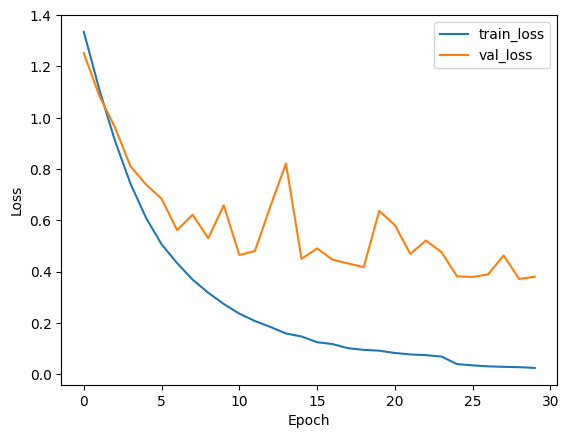

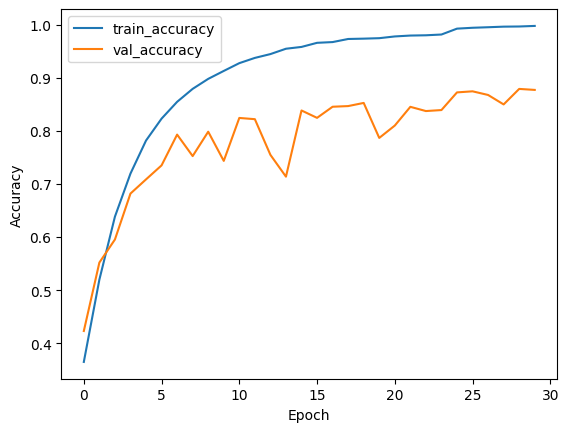

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


## Evaluation

In [ ]:
from sklearn.metrics import roc_curve, auc
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

201/201 [==============================] - 10s 29ms/step


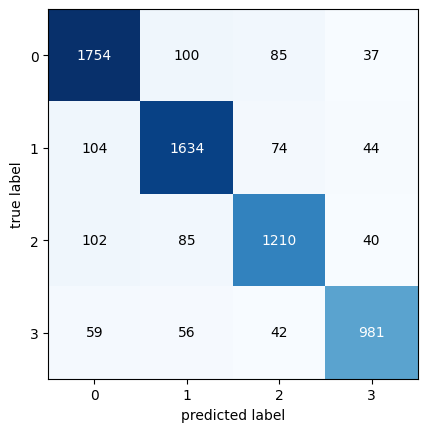

In [ ]:
predictions = new_model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

true_labels = np.argmax(test_labels, axis=1)

cm = confusion_matrix(true_labels, predicted_labels)

fig, ax = plot_confusion_matrix(conf_mat=cm)

In [ ]:
from sklearn.metrics import precision_score, recall_score, fbeta_score

precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f2_score = fbeta_score(true_labels, predicted_labels, beta=2, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F2 Score:", f2_score)

Precision: 0.8708333771149301
Recall: 0.8707663493054472
F2 Score: 0.8707197286925651


In [ ]:
class_labels = label_encoder.classes_

print("Class Labels:")
for i, label in enumerate(class_labels):
    print(f"Class {i}: {label}")

Class Labels:
Class 0: Astrocytoma
Class 1: Glioblastoma
Class 2: Oligodendroglioma
Class 3: abnormality


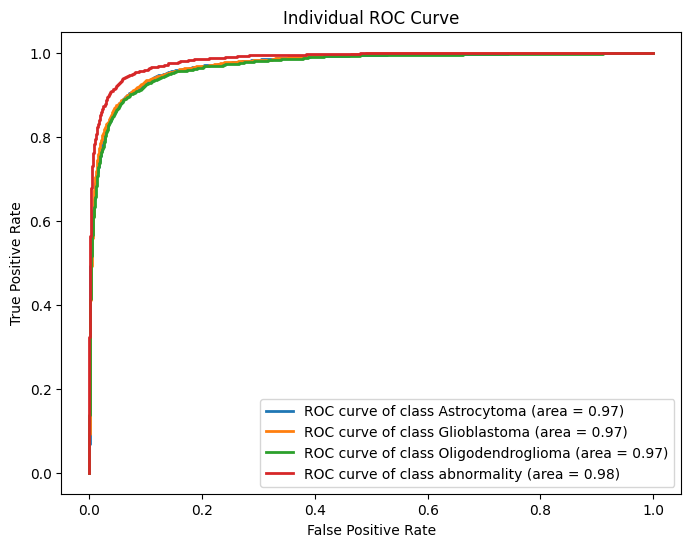

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(test_labels[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i in range(4):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve of class %s (area = %0.2f)' % (class_labels[i], roc_auc[i]))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Individual ROC Curve')
plt.legend(loc='lower right')
plt.show()


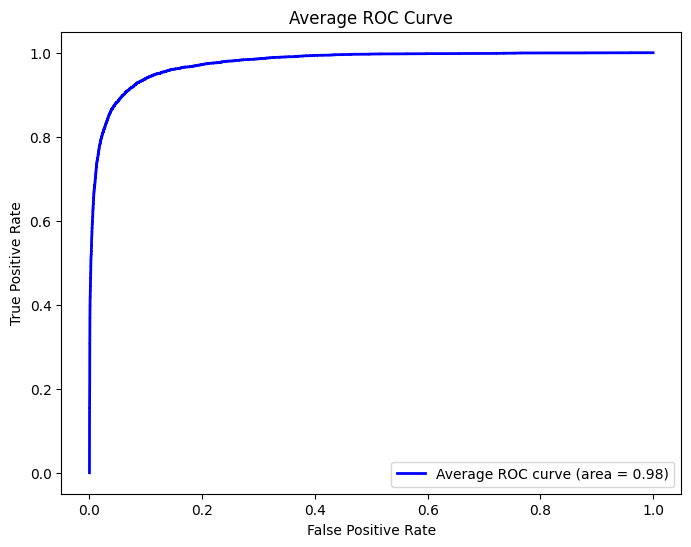

In [ ]:
fpr_avg, tpr_avg, _ = roc_curve(test_labels.ravel(), predictions.ravel())
roc_auc_avg = auc(fpr_avg, tpr_avg)

plt.figure(figsize=(8, 6))
plt.plot(fpr_avg, tpr_avg, color='blue', lw=2, label='Average ROC curve (area = %0.2f)' % roc_auc_avg)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Average ROC Curve')
plt.legend(loc='lower right')
plt.show()
